In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.utils import pretty_lat, pretty_lon, ProgressStatus, plot_n_steps_of_area_from_nc_file
from tempfile import TemporaryDirectory

In [2]:
from station.data_submission import DataSubmission
from station.station import StationData

from train_station_twin.training_executer import TrainingExecuter
from infilling.evaluation_executer import EvaluationExecuter
from infilling.infilling_writer import InfillingWriter

from era5.era5_for_station import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_download_hook import Era5DownloadHook
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [11]:
era5_hook = Era5DownloadHook(lat=0, lon=0)
era5_hook.coordinate_limits = {
    "north": 90,
    "south": -90,
    "west": -179.9,
    "east": 179.9
}

date = pd.Timestamp("2020-01-01")
folder = tempfile.TemporaryDirectory()
era5_target_file_path = f"{folder.name}/era5.nc"
era5_hook.download_hours_on_same_day(
    year=date.year,
    month=date.month,
    day=date.day,
    hours=[0,3,6,9,12,15,18,21],
    target_folder=folder.name
)
    

2024-05-05 18:01:16,429 INFO Welcome to the CDS
2024-05-05 18:01:16,429 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-05-05 18:01:16,723 INFO Request is queued
2024-05-05 18:01:17,828 INFO Request is running
2024-05-05 18:01:25,168 INFO Request is completed
2024-05-05 18:01:25,170 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data2/adaptor.mars.internal-1714924876.7578268-28499-3-9f36011d-d738-4f91-8277-d46e31d105e3.grib to /var/folders/yj/k7pg73d56rl366r8bvlbncgm0000gn/T/tmpwknrwvcb/2020_1_1.grib (15.8M)
2024-05-05 18:01:26,819 INFO Download rate 9.6M/s   


Found 2020_1_1.grib
Renamed variable var167 to tas in /var/folders/yj/k7pg73d56rl366r8bvlbncgm0000gn/T/tmpvlghliqy/2020_1_1.nc
Found 2020_1_1.nc
Merged era5 file saved into /var/folders/yj/k7pg73d56rl366r8bvlbncgm0000gn/T/tmpwknrwvcb/era5.nc
<xarray.Dataset> Size: 33MB
Dimensions:  (time: 8, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 64B 2020-01-01 ... 2020-01-01T21:00:00
  * lon      (lon) float64 12kB 180.1 180.3 180.6 180.8 ... 539.4 539.6 539.9
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    tas      (time, lat, lon) float32 33MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Sun May 05 18:01:28 2024: cdo cat /var/folders/yj/k7pg73d56...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...


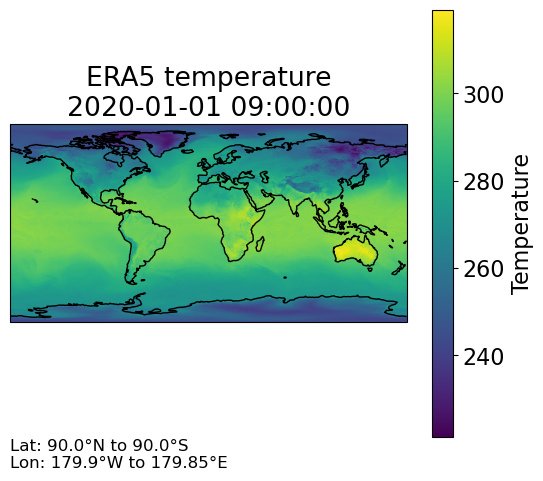

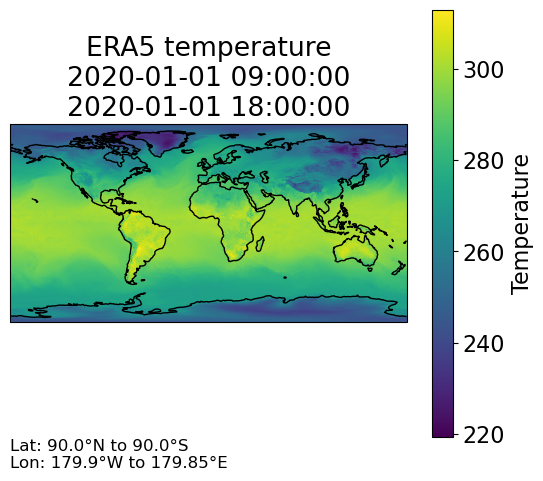

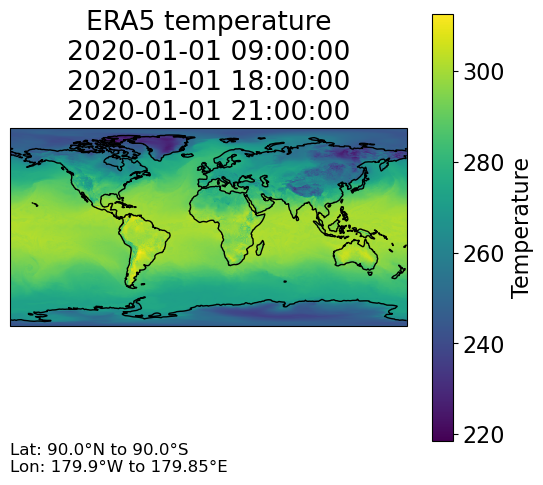

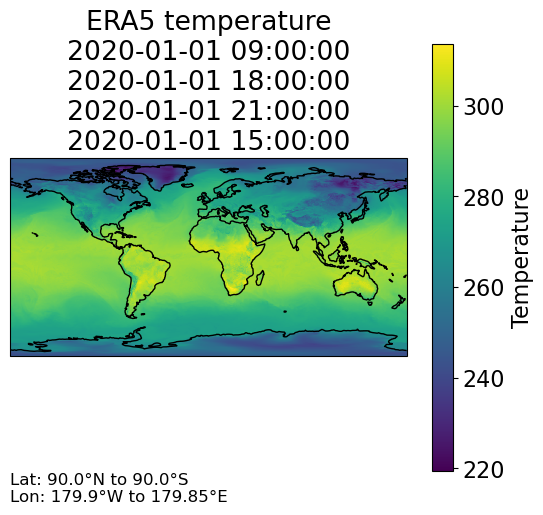

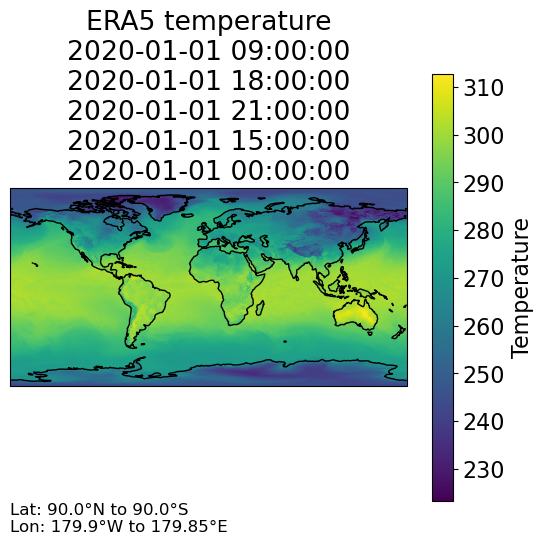

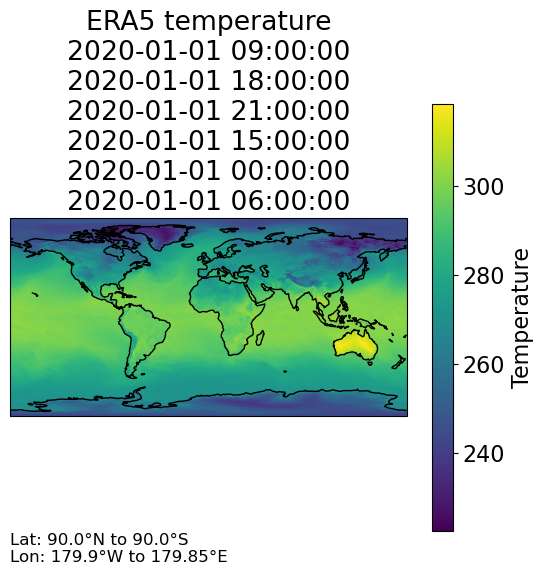

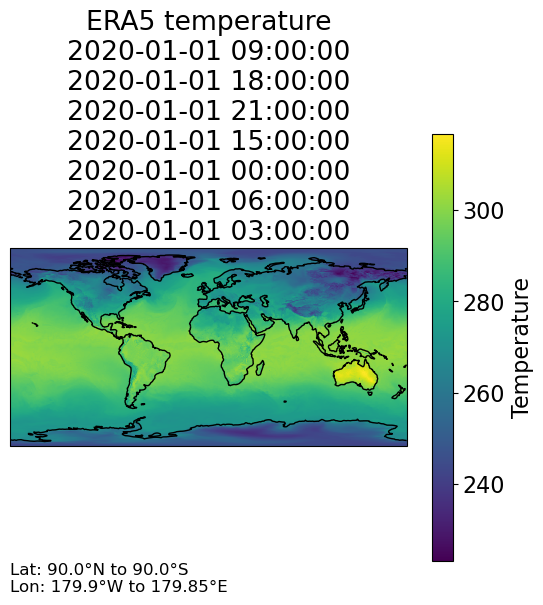

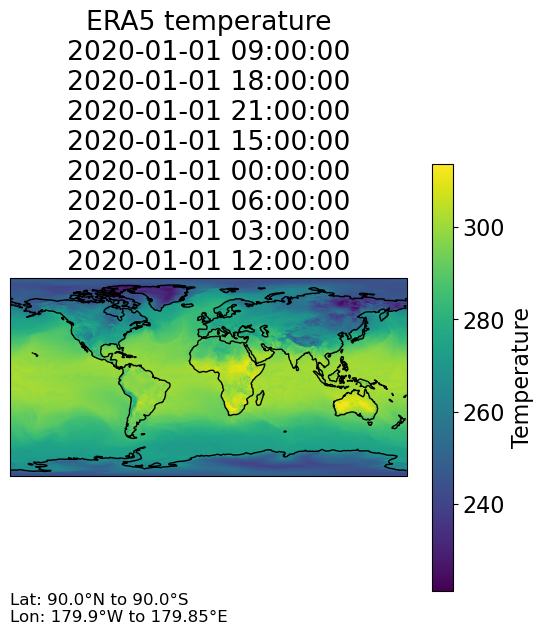

array([3, 6, 7, 5, 0, 2, 1, 4])

In [12]:
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc

# conversion
Era5DataFromGribToNc(
    folder_path=folder.name,
    era5_target_file_path=era5_target_file_path
)

print(xr.open_dataset(era5_target_file_path))

# plot the data
plot_n_steps_of_area_from_nc_file(
    path=era5_target_file_path,
    n=8,
    vars="tas",
    title="ERA5 temperature",
)

In [5]:
barbados_data = DataSubmission("Barbados")
barbados_data.measurement_dir_path = "./measurements/Barbados/"

barbados_station = StationData(
    name=barbados_data.name,
    folder_path=barbados_data.measurement_dir_path
)

Extracting Barbados...


100%|██████████| 1263/1263 [01:58<00:00, 10.70it/s]


In [6]:
# start date
start_date = "2020-01-01"
# end date
end_date = "2020-12-31"

# slice the df barbados_station.df
df = barbados_station.df.loc[start_date:end_date]
df

,vis_light,uv_light,ir_light,tas
datetime,,,,
2020-06-23 18:00:00,716.931034,246.517241,5135.344828,301.148276
2020-06-23 19:00:00,512.883333,137.083333,2969.266667,299.438333
2020-06-23 20:00:00,427.733333,91.516667,2080.833333,299.860000
2020-06-23 21:00:00,314.633333,30.900000,839.716667,299.188333
2020-06-23 22:00:00,266.316667,5.100000,315.800000,298.666667
...,...,...,...,...
2020-12-31 19:00:00,511.050000,136.116667,2856.783333,299.880769
2020-12-31 20:00:00,360.931034,55.637931,1277.741379,298.935714
2020-12-31 21:00:00,279.233333,11.950000,459.116667,298.241667


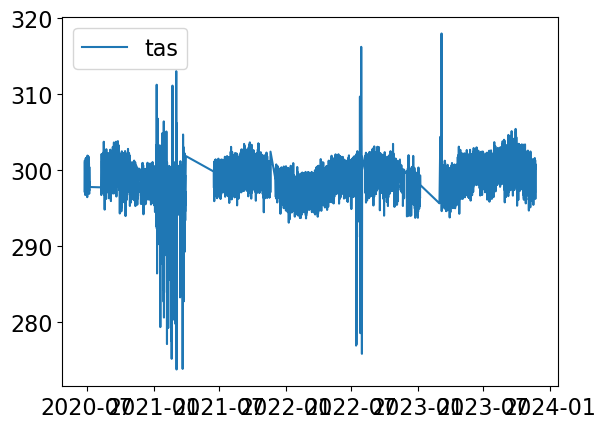

In [7]:

from utils.utils import plot_measurements_df
plot_measurements_df(barbados_station.df)

**Plot a few random timesteps of the weather station:**

In [8]:
random_timesteps = marshall_station.df.index

NameError: name 'marshall_station' is not defined

In [ ]:

training = TrainingExecuter(station=marshall_station, ProgressStatus())

output_model_path = training.execute()
marshall_data.add_model(output_model_path)



In [ ]:
barbados_station = StationData("Barbados", "./measurements/Barbados/")
vienna_station = StationData("Vienna", "./measurements/Vienna/")